In [3]:
import pm4py
import pandas as pd

In [4]:
log = pm4py.read_xes("log.xes")

/home/kramer/Documents/UTFPR/Mineracao/codes/mineracao_de_processos_trabalho_final/.venv/lib/python3.12/site-packages/pm4py/utils.py:992: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")
/home/kramer/Documents/UTFPR/Mineracao/codes/mineracao_de_processos_trabalho_final/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 100000/100000 [00:40<00:00, 2440.09it/s]


#### Lista as 10 principais variantes do log de eventos

In [5]:
from pm4py.statistics.variants.log import get as variants_get
variants = variants_get.get_variants(log)

from collections import Counter
c = Counter({k: len(v) for k,v in variants.items()})
for v,f in c.most_common(10):
    print(f, ":", v)

33673 : ('NEW', 'CHANGE DIAGN', 'FIN', 'RELEASE', 'CODE OK', 'BILLED')
22373 : ('NEW',)
20902 : ('NEW', 'FIN', 'RELEASE', 'CODE OK', 'BILLED')
4813 : ('NEW', 'DELETE')
3508 : ('NEW', 'FIN')
2121 : ('NEW', 'CHANGE DIAGN', 'CHANGE DIAGN', 'FIN', 'RELEASE', 'CODE OK', 'BILLED')
1555 : ('NEW', 'CHANGE DIAGN', 'DELETE')
977 : ('NEW', 'FIN', 'RELEASE', 'CODE NOK', 'BILLED')
869 : ('NEW', 'CHANGE DIAGN', 'FIN', 'RELEASE', 'CODE OK', 'REOPEN', 'FIN', 'RELEASE', 'CODE OK', 'BILLED')
512 : ('NEW', 'FIN', 'RELEASE', 'CODE OK', 'BILLED', 'CODE OK')


#### Conversão de log para DataFrame

In [6]:
from pm4py.objects.conversion.log import converter as log_converter

df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)

df = df.rename(columns={
    "case:concept:name": "case",
    "concept:name": "activity",
    "time:timestamp": "timestamp"
})
df["activity"] = df["activity"].str.upper().str.strip().str.replace(" ", "_")
df.head()


,isCancelled,diagnosis,timestamp,caseType,speciality,org:resource,activity,blocked,isClosed,flagD,...,lifecycle:transition,case,closeCode,actRed,actOrange,flagC,msgCount,version,msgType,msgCode
0,False,A,2012-12-16 19:33:10+00:00,A,A,ResA,NEW,False,True,True,...,complete,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2013-12-15 19:00:37+00:00,NaN,NaN,NaN,FIN,NaN,NaN,NaN,...,complete,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2013-12-16 03:53:38+00:00,NaN,NaN,NaN,RELEASE,NaN,NaN,NaN,...,complete,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2013-12-17 12:56:29+00:00,NaN,NaN,NaN,CODE_OK,NaN,NaN,NaN,...,complete,A,NaN,False,False,False,0.0,A,NaN,NaN
4,NaN,NaN,2013-12-19 03:44:31+00:00,NaN,NaN,ResB,BILLED,NaN,NaN,NaN,...,complete,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Ordena dataframe por timestamp 

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(["case", "timestamp"])


#### Elimina traços que tenham tamanho menor que 1 
Foi utilizado pois 22373 casos simplesmente são iniciados e em seguida finalizados, causando ruido: ('NEW',)

In [8]:
df = df[df["activity"] != "EMPTY"]
trace_sizes = df.groupby("case").size()
valid_cases = trace_sizes[trace_sizes > 1].index
df = df[df["case"].isin(valid_cases)]


#### Remove os traços 1% mais raros

In [9]:
activity_counts = df["activity"].value_counts()

threshold = activity_counts.quantile(0.01)  

common_activities = activity_counts[activity_counts >= threshold].index
df = df[df["activity"].isin(common_activities)]
print(activity_counts)

activity
NEW             78916
FIN             74738
RELEASE         70926
CODE_OK         68006
BILLED          67448
CHANGE_DIAGN    45451
DELETE           8225
REOPEN           4669
CODE_NOK         3620
STORNO           2973
REJECT           2016
SET_STATUS        705
MANUAL            372
JOIN-PAT          358
CODE_ERROR         75
CHANGE_END         38
ZDBC_BEHAN          1
Name: count, dtype: int64


#### Converte novamente para event log 

In [10]:
case_activities = df.groupby("case")["activity"].unique()

valid_cases = case_activities[case_activities.apply(lambda acts: any(a != "NEW" for a in acts))].index

df = df[df["case"].isin(valid_cases)]

In [11]:
log_clean = pm4py.format_dataframe(
    df,
    case_id='case',
    activity_key='activity',
    timestamp_key='timestamp'
)

log_clean = pm4py.convert_to_event_log(log_clean)

#### Cria rede de petri com o log limpo

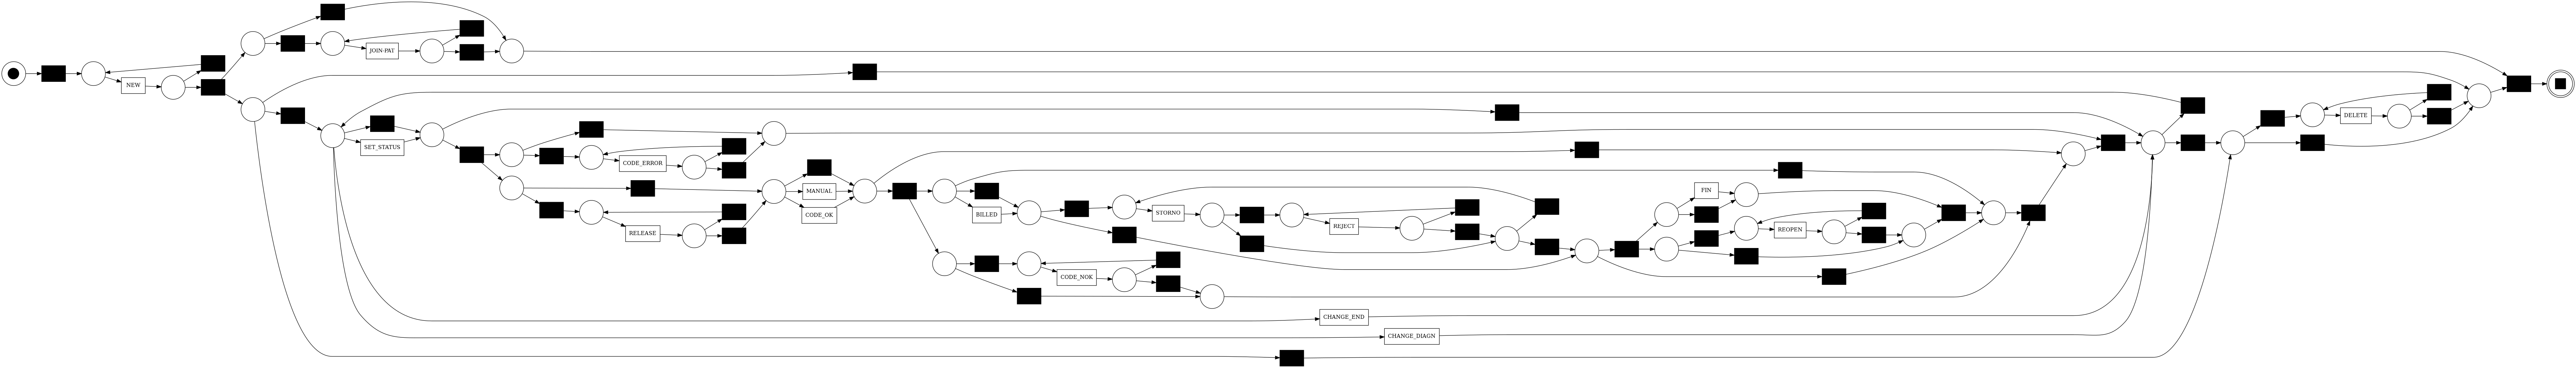

In [12]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.conversion.process_tree import converter as pt_converter

tree = inductive_miner.apply(log_clean)
net, im, fm = pt_converter.apply(tree)
pm4py.view_petri_net(net, im, fm)



In [ ]:
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
import pandas as pd

# ---- LOG ORIGINAL ----
aligned_original = alignments.apply_log(log, net, im, fm)

# Token-based fitness (LOG ORIGINAL)
token_res_original = token_replay.apply(log, net, im, fm)
fitness_original_token = token_replay.evaluate(token_res_original)

# Alignment-based fitness (LOG ORIGINAL)
fitness_original_align = alignments.evaluate(aligned_original)

# Relatório por caso (LOG ORIGINAL)
df_case_fitness_original = pd.DataFrame([
    {"case_id": ali["case_id"], "fitness": ali["fitness"]}
    for ali in aligned_original
])

# ---- LOG CLEAN ----
aligned_clean = alignments.apply_log(log_clean, net, im, fm)

# Token-based fitness (LOG CLEAN)
token_res_clean = token_replay.apply(log_clean, net, im, fm)
fitness_clean_token = token_replay.evaluate(token_res_clean)

# Alignment-based fitness (LOG CLEAN)
fitness_clean_align = alignments.evaluate(aligned_clean)

# Relatório por caso (LOG CLEAN)
df_case_fitness_clean = pd.DataFrame([
    {"case_id": ali["case_id"], "fitness": ali["fitness"]}
    for ali in aligned_clean
])

# =====================================================
# COMPARAÇÃO GERAL
# =====================================================
print("\n============= COMPARAÇÃO DE CONFORMIDADE =============")

print(">>> Token-Based Fitness")
print("Log Original :", fitness_original_token)
print("Log Clean    :", fitness_clean_token)

print("\n>>> Alignment-Based Fitness")
print("Log Original :", fitness_original_align)
print("Log Clean    :", fitness_clean_align)

# =====================================================
# DISTRIBUIÇÃO DE FITNESS POR TRACE
# =====================================================
print("\n============= DISTRIBUIÇÃO DE FITNESS POR TRACE =============")
print("Primeiras linhas do LOG ORIGINAL:")
print(df_case_fitness_original.head())

print("\nPrimeiras linhas do LOG CLEAN:")
print(df_case_fitness_clean.head())


aligning log, completed variants :: 100%|██████████| 1020/1020 [09:04<00:00,  1.87it/s] 


AttributeError: module 'pm4py' has no attribute 'fitness_token_based'

#### Exporta novamente para XES

In [ ]:
from pm4py.objects.log.exporter.xes import exporter as xes_exporter

xes_exporter.apply(log_clean, "log_clean.xes")

exporting log, completed traces :: 100%|██████████| 77627/77627 [00:56<00:00, 1377.29it/s]
